# DM-34065: rotation test 2, first implementation

* Turn off all perturbations again, but this time use the cmd file to add back 1 Zernike perturbation at a time to M1 only.  I’d suggest an amplitude of maybe 250 nm.
* Single star on the boresight.
* For each Zernike index 4-22 (or some subset if this is too much), make a plot of the estimated Zernike coefficient vs input rotation angle.  You should get sine waves for these, with periods as follows:
 * Z4, Z11, Z22 estimated Zernikes are independent of input rotation angle.
 * Z7, Z8, Z16, Z17 period is 360 degrees
 * Z5, Z6, Z12, Z13 period is 180 degrees
 * Z9, Z10, Z18, Z19 period is 120 degrees
 * Z14, Z15, period is 90 degrees
 * Z20, Z21, period is 72 degrees

* I predict that the above are periodic with rotTelPos, but not rotSkyPos.

* Note that phosim injects circular Zernikes, but ts_wep is estimating annular Zernikes, so we don’t expect to recover 2*250 nm (reflection so path length changes by 500nm!) if we inject a 250 nm perturbation.

Ticket: https://jira.lsstcorp.org/browse/DM-34066

I take the `cmd` and `inst` files from `0` rotation  test 1 as a basis 

I take the `cmd` and `inst` files from the `0` rotation as a basis, but I write new ones adding `izernike` commands. 

The `inst` file contains:
    
    Opsim_obshistid 9006001 
    Opsim_filter 1 
    mjd 59580.0000000000 
    SIM_SEED 1000 
    rightascension 0.030000 
    declination -0.020000 
    rotskypos 0.000000 
    rottelpos 0
    SIM_VISTIME 15.0
    SIM_NSNAP 1
    Opsim_rawseeing -1
    move 10 -1500.0000 
    camconfig 3 
    object  0	359.765300	-0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 0.0 none none 
    object  1	359.765300	 0.000000 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 1.0 none none 
    object  2	359.765300	 0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 2.0 none none 
    object  3	 0.000000	-0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 3.0 none none 
    object  4	 0.000000	 0.000000 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 4.0 none none 
    object  5	 0.000000	 0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 5.0 none none 
    object  6	 0.234700	-0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 6.0 none none 
    object  7	 0.234700	 0.000000 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 7.0 none none 
    object  8	 0.234700	 0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 8.0 none none 

( and `move 10 +1500.0` for intra-focal.) And we'll use the same for all. 

The `cmd` files contain 

    backgroundmode 0
    raydensity 0.0
    perturbationmode 1
    trackingmode 0
    cleartracking
    clearclouds
    lascatprob 0.0
    contaminationmode 0
    diffractionmode 1
    straylight 0
    detectormode 0
    centroidfile 1
    izernike 0 4 2.5e-4
    
In `izernike 0 4` the number stands for `surfaceId 0`, `zk 4` from https://github.com/lsst-ts/ts_phosim/blob/ac34fe47154361e96cefcb687a3e12d8c0a515b3/python/lsst/ts/phosim/telescope/PhosimCommu.py#L107 . Teh surfaces are: 

    0 = M1
    1 = M2
    2 = M3
    3 = L1F # Lens 1 front
    4 = L1B # Lens 1 back 
    5 = L2F # Lens 2 front
    6 = L2B # Lens 2 back 
    7 = FilterF # filter front 
    8 = FilterB # filter back 
    9 = L3F # Lens 3 front
    10 = L3B # Lens 3 back 
    11 = FP # ?? 
    12 = Chip # the CCD 

They are in `mm` https://github.com/lsst-ts/ts_phosim/blob/a76ec2561f56ff1f3d31f90d3fb0bebd09cb2ce3/python/lsst/ts/phosim/telescope/PhosimCommu.py#L211  , so 2.5e-4 is 250 nanometers converted to mm (250e-9 m = 2.5e-7m = 2.5e-4(e-3)m = 2.5e-4 mm ) 



In this case 
All that's needed is to :

* create  two extra/intra inst files 
* create one cmd file per zk simulated
* ingest raws and ISR -- pipetask 
* run donut detection and Zk estimation -- pipetask 

This can be done if I make a custom `getPistonArgsAndFilesForPhosim()`, so that `closeLoopTask` instead of relying on `PhosimCmpt` is using the custom `cmd` and `inst` file here https://github.com/lsst-ts/ts_phosim/blob/467a40d106d41c82c2d561a4593b33221f9b6ff3/python/lsst/ts/phosim/CloseLoopTask.py#L736 

This function also needs to return the appropriate run command for phosim.

Also, before that, need to make only 1 star at the center of R22_S11 (on the boresight), nothing else. That would require modification to existing `_setSkySimBasedOnOpdFieldPos` https://github.com/lsst-ts/ts_phosim/blob/467a40d106d41c82c2d561a4593b33221f9b6ff3/python/lsst/ts/phosim/CloseLoopTask.py#L113 , so that instead of using 9 OPD field positions, we use just one. I'd hope that would work - worth trying, so that simulation is much faster... 

That function stores the `skySim.addStarByRaDecInDeg(starId, raInDeg, declInDeg, starMag)` in `skySim`, which is later invoked only here below to return the `ra,deg` via `getPistonCamStarArgsAndFilesForPhoSim`.


The call to `getPistonArgsAndFilesForPhosim()` function was 


     argStringList = self.phosimCmpt.getPistonCamStarArgsAndFilesForPhoSim(
            extraObsId,
            intraObsId,
            self.skySim,
            simSeed=simSeed,
            cmdSettingFileName="starDefault.cmd",
            instSettingFileName="starSingleExp.inst",
        )
and the function signature https://github.com/lsst-ts/ts_phosim/blob/467a40d106d41c82c2d561a4593b33221f9b6ff3/python/lsst/ts/phosim/PhosimCmpt.py#L634

     def getPistonCamStarArgsAndFilesForPhoSim(
            self,
            extraObsId,
            intraObsId,
            skySim,
            simSeed=1000,
            cmdSettingFileName="starDefault.cmd",
            instSettingFileName="starSingleExp.inst",
        ):

instead of `self` below refer to `closeLoop.phosimCmpt.`:

I provide `skyFile` with just one star on the boresight:
    
    # Id Ra Decl Mag
    0 0.0 0.0  15

to make the inst file using the `ts_phosim` tools, but I do change how `cmd` file is made so that just a single `izernike` line is used. 



In [1]:
%matplotlib inline
import os
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import imp
imp.reload(at)

import os
import shutil
import logging

import astropy.io.ascii

import numpy as np

from lsst.afw.cameraGeom import DetectorType
from lsst.daf import butler as dafButler
from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.ts.phosim.PhosimCmpt import PhosimCmpt
from lsst.ts.phosim.utils.Utility import getPhoSimPath, getAoclcOutputPath, getCamera
from lsst.ts.phosim.telescope.TeleFacade import TeleFacade



In [23]:
def runCloseLoopTaskSingleStarZkPert(baseOutputDir,
                     rotCamInDeg=0,
                     iterNum=1,
                     numPro=20,
                     boresight=[0,0],
                     pathSkyFile='/project/scichris/aos/rotation_DM-34065/singleStarBoresight00.txt',
                     useEimg=False,
                     inst='comcam',
                     filterTypeName='',
                     m1m3ForceError=0,
                     zAngleInDeg=27.0912,
                     seedNum=6,
                     surfaceId = 0 ,
        zernikeNumber = 4,
        zernikeInNm = 250
                     ):
    ''' 
    
    surfaceId: int, optional
        0 = M1
        1 = M2
        2 = M3
        3 = L1F # Lens 1 front
        4 = L1B # Lens 1 back 
        5 = L2F # Lens 2 front
        6 = L2B # Lens 2 back 
        7 = FilterF # filter front 
        8 = FilterB # filter back 
        9 = L3F # Lens 3 front
        10 = L3B # Lens 3 back 
        11 = FP # ?? 
        12 = Chip # the CCD 
        (default 0)
    zernikeNumber: int, optional
        Zernike number to simulate, starts from 0
        (default 4)
    zernikeInNm: int, optional
        Value for zernike perturbation imparted on surfaceId
        via izernike command in phoSim's cmd file
        (default: 250 nm)
    '''
    
    # initialize the task afresh 
    closeLoop = CloseLoopTask()

    camType, instName = closeLoop.getCamTypeAndInstName(inst)

    filterType = closeLoop.getFilterType(filterTypeName)

    print(baseOutputDir)
    baseOutputDir = closeLoop.checkAndCreateBaseOutputDir(baseOutputDir)

    closeLoop.checkBoresight(boresight, pathSkyFile)

    closeLoop.assignImgType(useEimg)

    # I config skySim so that it adds stars based on OPD,
    # i.e. in the middle, but I only choose the first one 
    closeLoop.configSkySim(instName, pathSkyFile=pathSkyFile, starMag=15)

    closeLoop.configOfcCalc(instName)
    
    
    # 
    # begin self.configPhosimCmpt
    #          

    rotAngInDeg = rotCamInDeg

    closeLoop.boresightRa = boresight[0]
    closeLoop.boresightDec = boresight[1]
    closeLoop.boresightRotAng = rotAngInDeg

    # Set the Telescope facade class
    tele = TeleFacade()
    #tele.addSubSys(addCam=True, addM1M3=False, addM2=False)

    phosimDir = getPhoSimPath()
    tele.setPhoSimDir(phosimDir)

    # Prepare the phosim component
    closeLoop.phosimCmpt = PhosimCmpt(tele)

    # Set the telescope survey parameters
    closeLoop.phosimCmpt.setSurveyParam(
        filterType=filterType,
        boresight=tuple(boresight),
        zAngleInDeg=zAngleInDeg,
        rotAngInDeg=rotAngInDeg,
    )

    # Set the M1M3 force error
    closeLoop.phosimCmpt.setM1M3ForceError(m1m3ForceError)

    # Update the number of processor if necessary
    if numPro > 1:
        settingFile = closeLoop.phosimCmpt.getSettingFile()
        settingFile.updateSetting("numPro", numPro)

    # Set the seed number for M1M3 surface
    closeLoop.phosimCmpt.setSeedNum(seedNum)


    #
    # end of self.configPhosimCmpt
    # 
    
    # generate butler gen3 repo if needed
    butlerRootPath = os.path.join(baseOutputDir, "phosimData")
    if closeLoop.useCcdImg():
        closeLoop.generateButler(butlerRootPath, instName)
        closeLoop.generateRefCatalog(
            instName=instName,
            butlerRootPath=butlerRootPath,
            pathSkyFile=pathSkyFile,
        )

    # set the camType
    closeLoop.phosimCmpt.tele.setInstName(camType)

    
    # now instead of caling the `_runSim`, which inside calls `PhosimCmpt.getPistonCamStarArgsAndFilesForPhoSim(),
    # need to call the parts directly because I need to make the `cmd` file in a different way ...

    # self --> closeLoop
    # Run just one iteration of the simulation
    # closeLoop._runSim(
    #             camType=camType,
    #             instName=instName,
    #             filterType=filterTypeName,
    #             rotCamInDeg=rotCamInDeg,
    #             iterNum=iterNum,
    #             numPro=numPro,
    #             baseOutputDir=baseOutputDir,
    #             butlerRootPath=butlerRootPath,
    #         )

    #
    #
    #  begin _runSim()
    #
    #

    # so for the below I need to reassign some variables so their name is convenient
    filterType=filterTypeName
    # Set the telescope state to be the same as the OFC
    state0 = closeLoop.ofcCalc.ofc_controller.aggregated_state
    closeLoop.phosimCmpt.setDofInUm(state0)

    # Get the list of referenced sensor name (field positions)
    refSensorNameList = closeLoop.getSensorNameListOfFields(instName)
    refSensorIdList = closeLoop.getSensorIdListOfFields(instName)

    # Common file and directory names
    opdZkFileName = "opd.zer"
    opdPssnFileName = "PSSN.txt"
    outputDirName = "pert"
    outputImgDirName = "img"
    iterDefaultDirName = "iter"
    dofInUmFileName = "dofPertInNextIter.mat"
    fwhmItersFileName = "fwhmIters.png"

    # Specific file names to the amplifier/eimage
    wfsZkFileName = "wfs.zer"

    # Do the iteration
    obsId = 9006000
    iterCount=0
    
    # Set the observation Id
    closeLoop.phosimCmpt.setSurveyParam(obsId=obsId)

    # The iteration directory
    iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

    # Set the output directory
    outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
    closeLoop.phosimCmpt.setOutputDir(outputDir)

    # Set the output image directory
    outputImgDir = os.path.join(baseOutputDir, iterDirName, outputImgDirName)
    closeLoop.phosimCmpt.setOutputImgDir(outputImgDir)

    # I skip this part of OPD generation and analysis...
    #
    # Generate the OPD image
    # argString = self.phosimCmpt.getOpdArgsAndFilesForPhoSim(instName)
    # self.log.info(f"PHOSIM OPD ARGSTRING: {argString}")

    # self.phosimCmpt.runPhoSim(argString)

    # # Analyze the OPD data
    # # Rotate OPD in the reversed direction of camera
    # self.phosimCmpt.analyzeOpdData(
    #     instName,
    #     zkFileName=opdZkFileName,
    #     rotOpdInDeg=-rotCamInDeg,
    #     pssnFileName=opdPssnFileName,
    # )

    # # Get the PSSN from file
    # pssn = self.phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
    # self.log.info("Calculated PSSN is %s." % pssn)

    # # Get the GQ effective FWHM from file
    # gqEffFwhm = self.phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
    # self.log.info("GQ effective FWHM is %.4f." % gqEffFwhm)

    # # Set the FWHM data
    # fwhm, sensor_id = self.phosimCmpt.getListOfFwhmSensorData(
    #     opdPssnFileName, refSensorIdList
    # )
    # self.ofcCalc.set_fwhm_data(fwhm, sensor_id)
    
    # I delve inside "_calcWfErrFromImg" because 
    # that's where getPistonCamStarArgsAndFilesForPhoSim is made ...

    # Generate the sky images and calculate the wavefront error
    # if self.useCcdImg():
    #     listOfWfErr = self._calcWfErrFromImg(
    #         obsId,
    #         butlerRootPath=butlerRootPath,
    #         instName=instName,
    #         snap=0,
    #         numPro=numPro,
    #     )


    snap=0; simSeed=1000
    # Assign the entra- and intra-focal observation Id
    extraObsId = obsId + 1
    intraObsId = obsId + 2


    # Now I delve inside phosimCmpt.getPistonCamStarArgsAndFilesForPhoSim()
    # to create the inst file as-is, but modify the cmd file 

    # here self --> closeLoop.phosimCmpt.

    # Generate the defocal images
    # argStringList = self.phosimCmpt.getPistonCamStarArgsAndFilesForPhoSim(
    #     extraObsId,
    #     intraObsId,
    #     self.skySim,
    #     simSeed=simSeed,
    #     cmdSettingFileName="starDefault.cmd",
    #     instSettingFileName="starSingleExp.inst",
    # )

    # with a signature of 
    # def getPistonCamStarArgsAndFilesForPhoSim(
    #         self,
    #         extraObsId,
    #         intraObsId,
    #         skySim,
    #         simSeed=1000,
    #         cmdSettingFileName="starDefault.cmd",
    #         instSettingFileName="starSingleExp.inst",
    #     ):

    # Set the intra- and extra-focal related information
    obsIdList = {"-1": extraObsId, "1": intraObsId}
    instFileNameList = {"-1": "starExtra.inst", "1": "starIntra.inst"}
    logFileNameList = {"-1": "starExtraPhoSim.log", "1": "starIntraPhoSim.log"}

    extraFocalDirName = closeLoop.phosimCmpt.getExtraFocalDirName()
    intraFocalDirName = closeLoop.phosimCmpt.getIntraFocalDirName()
    outImgDirNameList = {"-1": extraFocalDirName, "1": intraFocalDirName}

    # Write the instance and command files of defocal conditions
    cmdFileName = "star.cmd"
    onFocalDofInUm = closeLoop.phosimCmpt.getDofInUm()
    onFocalOutputImgDir = closeLoop.phosimCmpt.outputImgDir

    
    argStringList = []
    for ii in (-1, 1):
        #ii = -1
        # Set the observation ID
        closeLoop.phosimCmpt.setSurveyParam(obsId=obsIdList[str(ii)])

        # Camera piston (Change the unit from mm to um)
        pistonInUm = np.zeros(len(onFocalDofInUm))
        pistonInUm[5] = ii * closeLoop.phosimCmpt.tele.getDefocalDistInMm() * 1e3
        #print(pistonInUm[5])
        #print(onFocalDofInUm)
        # Set the new DOF that considers the piston motion
        closeLoop.phosimCmpt.setDofInUm(onFocalDofInUm + pistonInUm)

        # Update the output image directory
        outputImgDir = os.path.join(onFocalOutputImgDir, outImgDirNameList[str(ii)])
        closeLoop.phosimCmpt.setOutputImgDir(outputImgDir)

        #
        #
        # begin PhosimCmpt.getStarArgsAndFilesForPhoSim()
        #
        #

        # now PhosimCmpt would call getStarArgsAndFilesForPhoSim()
        # Get the argument to run the phosim
        # argString = self.getStarArgsAndFilesForPhoSim(
        #     skySim,
        #     cmdFileName=cmdFileName,
        #     instFileName=instFileNameList[str(ii)],
        #     logFileName=logFileNameList[str(ii)],
        #     simSeed=simSeed,
        #     cmdSettingFileName=cmdSettingFileName,
        #     instSettingFileName=instSettingFileName,
        # )

        # with a signature of 

        # def getStarArgsAndFilesForPhoSim(
        #         self,
        #         skySim,
        #         cmdFileName="star.cmd",
        #         instFileName="star.inst",
        #         logFileName="starPhoSim.log",
        #         simSeed=1000,
        #         cmdSettingFileName="starDefault.cmd",
        #         instSettingFileName="starSingleExp.inst",
        #     ):
        cmdFileName="star.cmd"
        instFileName=instFileNameList[str(ii)]
        logFileName=logFileNameList[str(ii)]
        cmdSettingFileName="starDefault.cmd"
        instSettingFileName="starSingleExp.inst"

        # Now instead of calling _writePertAndCmdFiles()
        # to write the command file
        # cmdFilePath = closeLoop.phosimCmpt._writePertAndCmdFiles(cmdSettingFileName, cmdFileName)

        #
        #
        # begin _writePertAndCmdFiles()
        #
        #

        # Write the perturbation file
        pertCmdFileName = "pert.cmd"
        pertCmdFilePath = os.path.join(closeLoop.phosimCmpt.outputDir, pertCmdFileName)
        # if not os.path.exists(pertCmdFilePath):
        #     self.tele.writePertBaseOnConfigFile(
        #         self.outputDir,
        #         seedNum=self.seedNum,
        #         m1m3ForceError=self.m1m3ForceError,
        #         saveResMapFig=True,
        #         pertCmdFileName=pertCmdFileName,
        #     )


        # this calls TeleFacade.writePertBaseOnConfigFile()  and instead of using that,
        # I add this single zernike perturbation

        # inside TeleFacade.writePertBaseOnConfigFile()
        pertCmdFileDir = closeLoop.phosimCmpt.outputDir
        # Get the perturbation of subsystems
        
        zernikeInMm = zernikeInNm * 1e-6 # nm to mm 
        content = f"izernike {surfaceId} {zernikeNumber} {zernikeInMm}"
        # Write the perturbation command to file
        pertCmdFilePath = os.path.join(pertCmdFileDir, pertCmdFileName)
        # below 'self'  is actually TeleFacade... 
        closeLoop.phosimCmpt.tele.phoSimCommu.writeToFile(pertCmdFilePath, 
                                                          content=content, mode="w")


        # below self is PhosimCmpt... 
        # Write the physical command file
        cmdSettingFile = os.path.join(closeLoop.phosimCmpt.configDir, "cmdFile", cmdSettingFileName)
        cmdFilePath = os.path.join(closeLoop.phosimCmpt.outputDir, cmdFileName)

        closeLoop.phosimCmpt.tele.writeCmdFile(
                closeLoop.phosimCmpt.outputDir,
                cmdSettingFile=cmdSettingFile,
                pertFilePath=pertCmdFilePath,
        cmdFileName=cmdFileName,
            )

        #
        #
        # end  _writePertAndCmdFiles()
        #
        #

        # Write the instance file - this is fine because I already added just 
        # a single star via starFile.... 
        # self below is PhosimCmpt
        instSettingFile = closeLoop.phosimCmpt._getInstSettingFilePath(instSettingFileName)
        #print(closeLoop.phosimCmpt.tele.dofInUm)
        instFilePath = closeLoop.phosimCmpt.tele.writeStarInstFile(
            closeLoop.phosimCmpt.outputDir,
            closeLoop.skySim,
            simSeed=simSeed,
            sedName="sed_flat.txt",
            instSettingFile=instSettingFile,
            instFileName=instFileName,
            )

        # Get the argument to run the PhoSim
        argString = closeLoop.phosimCmpt._getPhoSimArgs(logFileName, instFilePath, cmdFilePath)

        #
        #
        # end of PhosimCmpt.getStarArgsAndFilesForPhoSim()
        # 
        # 

        #
        # back to PhosimCmpt.getPistonCamStarArgsAndFilesForPhoSim()
        #
        argStringList.append(argString)
    
    # Put the internal state back to the focal plane condition
    closeLoop.phosimCmpt.setDofInUm(onFocalDofInUm)
    closeLoop.phosimCmpt.setOutputImgDir(onFocalOutputImgDir)

    #
    #
    # end of getPistonCamStarArgsAndFilesForPhoSim 
    #
    #    

    #
    #
    # back to closeLoop._calcWfErrFromImg()
    # 
    # 

    # simulate one extra and one intra-focal images 
    for argString in argStringList:
        closeLoop.log.info(f"PHOSIM CCD ARGSTRING: {argString}")
        closeLoop.phosimCmpt.runPhoSim(argString)
        
    # Repackage the images based on the image type
    closeLoop.phosimCmpt.repackagePistonCamImgs(
        instName=instName if instName == "comcam" else "lsst", 
        isEimg=closeLoop.useEimg
    )

    # Ingest images into butler gen3
    closeLoop.ingestData(butlerRootPath=butlerRootPath, instName=instName)

    listOfWfErr = closeLoop.runWep(
        extraObsId, intraObsId, butlerRootPath, instName, numPro=numPro
    )

    #
    #
    # end of closeLoop._calcWfErrFromImg()
    # 
    # 

    # at this point, closeLoop.runWep() already stores the content
    # to a Gen3 repo, same as the one that holds raw and postISR images,
    # so no need to do next steps that are included in the closeLoop._runSim()

     

In [ ]:
# # Record the wavefront error with the same order as OPD for the
# # comparison
# if self.useCcdImg():
#     self.phosimCmpt.reorderAndSaveWfErrFile(
#         listOfWfErr,
#         refSensorNameList,
#         getCamera(instName),
#         zkFileName=wfsZkFileName,
#     )

# # Calculate the DOF
# wfe = np.array(
#     [sensor_wfe.getAnnularZernikePoly() for sensor_wfe in listOfWfErr]
# )
# sensor_ids = np.array(
#     [sensor_wfe.getSensorId() for sensor_wfe in listOfWfErr]
# )

# self.ofcCalc.calculate_corrections(
#     wfe=wfe,
#     field_idx=sensor_ids,
#     filter_name=str(filterType),
#     gain=-1,
#     rot=rotCamInDeg,
# )

# # Set the new aggregated DOF to phosimCmpt
# dofInUm = self.ofcCalc.ofc_controller.aggregated_state
# self.phosimCmpt.setDofInUm(dofInUm)

# # Save the DOF file
# self.phosimCmpt.saveDofInUmFileForNextIter(
#     dofInUm, dofInUmFileName=dofInUmFileName
# )

# # Add the observation ID by 10 for the next iteration
# obsId += 10

# # Summarize the FWHM
# pssnFiles = [
# os.path.join(
#     baseOutputDir,
#     "%s%d" % (iterDefaultDirName, num),
#     outputImgDirName,
#     opdPssnFileName,
# )
# for num in range(iterNum)
# ]
# saveToFilePath = os.path.join(baseOutputDir, fwhmItersFileName)
# plotFwhmOfIters(pssnFiles, saveToFilePath=saveToFilePath)

#
#
#  end _runSim()
#
#



Try quickly reading the products using a butler to make sure I get digestible results... 

In [18]:
import os
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import imp
imp.reload(at)

<module 'analysisTools' from '/project/scichris/aos/analysisTools.py'>

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


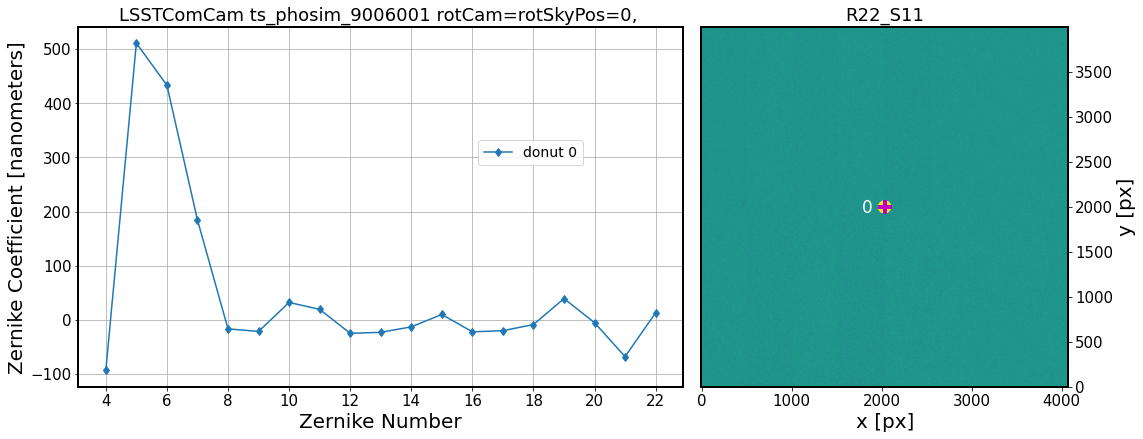

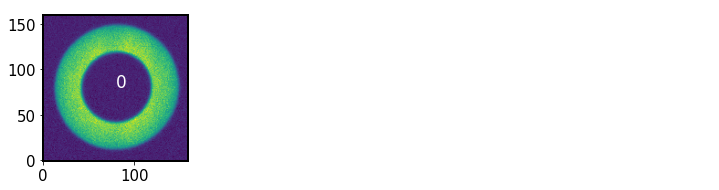

In [22]:
%matplotlib inline
iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test02_a/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')



In [ ]:
#Next: put the above into a function where zkNumer and rotation angle are different...
    
    
for rotCamInDeg in [-90,-60,-30,0,30,60,90]:   
    #set the output dir based on the rotation angle 
    if rotCamInDeg < 0:
        titleDeg = f'{str(rotCamInDeg)[1:]}n'
    else:
        titleDeg = f'{rotCamInDeg}'
    for zkNumber in np.arange(4,23):
        
        baseOutputDir = f'/project/scichris/aos/rotation_DM-34065/test01_a_rot{titleDeg}_zk{zkNumber}/'
        print(baseOutputDir)
        
        runCloseLoopTaskSingleStarZkPert(baseOutputDir,
                                         rotCamInDeg=rotCamInDeg, 
                                         zernikeNumber = zkNumber
                                        )

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk4/phosimData

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk5/phosimData

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk6/phosimData

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk7/phosimData

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk8/phosimData

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk9/phosimData

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk10/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk11/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk12/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk13/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk14/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk15/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk16/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk17/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk18/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]
Repackaging sen

lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defineVi

/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/
/project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/gc7c10ab807+2c5347a369/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g1c50ebbfb2+a5490838b4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/ga989976c98+181b941f47/python/lsst/daf/butler/cli/utils.py:886: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_rot90n_zk19/phosimDa

-1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[    0.     0.     0.     0.     0. -1500.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
1500.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[   0.    0.    0.    0.    0. 1500.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]


In [4]:
import numpy as np
jcount=0
jcountDic = {}
for zkNumber in np.arange(4,23):
    print(zkNumber, jcount)
    jcountDic[zkNumber]=jcount
    jcount += 1 

4 0
5 1
6 2
7 3
8 4
9 5
10 6
11 7
12 8
13 9
14 10
15 11
16 12
17 13
18 14
19 15
20 16
21 17
22 18


**Note**: this implementation had to be abandoned because it is too slow - each time the refcat creation / conversion took way too much time (longer than the phoSim simulation). Since it is not needed to re-create a refCat, I decided to pull parts of code and make it manually, without using `CloseLoopTask` class at all for better flexibility. 